#  Fit to analyze data from www.data.gouv.fr

**Note:** This is a Jupyter notebook which is also available as its executable export as a Python 3 script (therefore with automatically generated comments).

# Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')
print("For now, reduce python warnings, I will look into this later")

For now, reduce python warnings, I will look into this later


In [2]:
import os, sys

import math
import pandas            as PAN
import numpy             as NP
import numpy.random      as RAND
import scipy.stats       as STATS
from scipy import sparse
from scipy import linalg
from scipy import integrate
from scipy import optimize

# Better formatting functions; ensure that this work as script
from IPython.display import display, HTML
from IPython import get_ipython

### Import my own modules
The next cell attempts to give user some information if things improperly setup.
Intended to work both in Jupyter and when executing the Python file directly.

In [3]:
if not get_ipython() is None and os.path.abspath("../source/") not in sys.path:
    sys.path.append(os.path.abspath("../source/"))
try:
    from lib.utilities     import *
    from lib.figureHelpers import *
    from lib.DataMgrJSON   import *
    from lib.pandaUtils    import *
    from lib.basicUtils    import toDict
    import lib.basicDataCTE as DCTE
    import lib.epidemioModels as EPIM 
except Exception as err:
    print("Could not find library 'lib' with contents 'DataGouvFr' ")
    if get_ipython() is None:
        print("Check the PYTHONPATH environment variable which should point to 'source' wich contains 'lib'")
    else:
        print("You are supposed to be running in JupySessions, and '../source/lib' should exist")
    raise err

Loaded lib
For now, reduce python warnings, I will look into this later


In [4]:
checkSetup(chap="Fit01")
ImgMgr = ImageMgr(chapdir="Fit01")

# Models 
I thought of using either: 
- the methods exposed in Parameter Estimation and Uncertainty Quantification for an
Epidemic Model by  A. Capaldi et al.
- the method used in the tutorial 'Fitting Epidemic Models to Data' by J.H.Jones (http://web.stanford.edu/class/earthsys214/notes/fit.html) (with code in R)

Eventually, I turned to an expanded SEIR model inspired by the paper 
"**Epidemic analysis of COVID-19 in China by dynamical modeling**"
(*arxiv:2002.06563V1*), which includes *quarantined* and *insusceptible* categories. 
It includes fitted parameters for several areas in China. This corresponds to the equations:

- s: susceptibles
- p: insusceptibles
- e: exposedhe
- i: infected
- q: quarantined
- r: recovered
- d: dead

$$
\begin{eqnarray}
  \frac{ds}{dt}&=&  -\beta \frac{s i}{N} - \alpha s 
  \\
  \frac{de}{dt}&=&  \beta \frac{s i}{N} - \gamma e 
  \\
  \frac{di}{dt}&=&  \gamma e - \delta i 
  \\
  \frac{dq}{dt}&=&  \delta i - (\lambda + \kappa) q 
  \\
  \frac{dr}{dt}&=&  \lambda  q 
  \\
  \frac{dd}{dt}&=&  \kappa q 
  \\
  \frac{dp}{dt}&=&  \alpha s 
  \\
\end{eqnarray}
$$

# Data

### Load the data

In [5]:
dataFileVMgr = manageAndCacheDataFilesFRDG("../data")
dataFileVMgr.getRemoteInfo()
dataFileVMgr.updatePrepare()
dataFileVMgr.cacheUpdate()

Loaded pickle from ../data/.cache.json, loaded 6h 49m 59s ago (7 elts)
Skipping 'Population présente avant et après le début du confinement' fmt:None mod:2020-04-16T12:08:56.978000 org='institut-national-de-la-statistique-et-des-etudes-economiques-insee'


In [6]:
ad  = lambda x: "../data/"+x

In [7]:
last = lambda x: dataFileVMgr.getRecentVersion(x,default=True)
hospNouveauCsv = last("donnees-hospitalieres-nouveaux-covid19-2020-04-11-19h00.csv")
data_hospNouveau = read_csvPandas(ad(hospNouveauCsv), error_bad_lines=False,sep=";")
hospCsv = last("donnees-hospitalieres-covid19-2020-04-11-19h00.csv")
data_hosp = read_csvPandas(ad(hospCsv), error_bad_lines=False,sep=";")

Get the Insee data, it is not clear that this loads automagically (to be checked)


In [8]:
dataFileVMgrInsee = manageDataFileVersions("../dataPop") 
inseeDepXLS           ="../dataPop/InseeDep.xls"
inseeDep            = read_xlsxPandas(inseeDepXLS, error_bad_lines=False,sep=",", sheet_name=1, header=7)
inseeReg            = read_xlsxPandas(inseeDepXLS, error_bad_lines=False,sep=",", sheet_name=0, header=7)

Merge COVID and demographics data
See the `Pop-Data-FromGouv.ipynb` notebook for more details on the demographics data obtained from
INSEE (https://www.insee.fr/fr/accueil). Considerations on how to load and refresh this data will be handled there!

In [9]:
hndDf = data_hospNouveau.copy()
hndDf.set_index("dep");
hdDf = data_hosp.copy()
hdDf.set_index("dep");

Then we extract the demographic information and set index "dep" 

In [10]:
depStats = inseeDep.iloc[:,[2,3,7,8]].copy()
cols = depStats.columns.values
cols[0]="dep"
depStats.columns = cols
depStats.set_index("dep");

Now we perform the merge, and group by date and 'départements': 

In [11]:
hndMerged = PAN.merge(hndDf,depStats, on="dep" ) 
hndGrMerged=hndMerged.groupby(["jour","dep"]).sum()

In [12]:
hdMerged = PAN.merge(hdDf,depStats, on="dep" ) 
hdGrMerged=hdMerged.groupby(["jour","dep"]).sum()

In [13]:
hndGMJour = hndGrMerged.groupby("jour").sum()
colLabsIncid = ("incid_hosp", "incid_rea", "incid_dc", "incid_rad")
for lab in colLabsIncid:
    hndGMJour[lab+"_rate"] = hndGMJour[lab]/hndGMJour["Population totale"]*1.0e6

In [14]:
hdGMJour = hdGrMerged.groupby("jour").sum()
colLabs = ("hosp", "rea", "dc", "rad")
for lab in colLabs:
    hdGMJour[lab+"_rate"] = hdGMJour[lab]/hdGMJour["Population totale"]*1.0e6

And the graph can be readily generated for the entire country; this
also permits to verify that the data has been collected in a usable format:

Saving figure FIG050


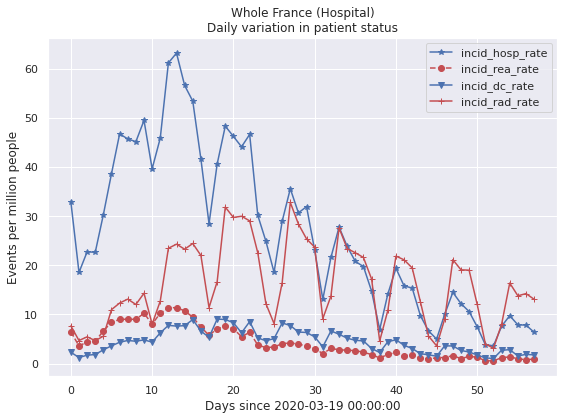

In [15]:
ncolLabs = list ( x+"_rate" for x in colLabsIncid)
df=hndGMJour.loc[:,ncolLabs]
colOpts = {'incid_dc_rate'  : {"c":"b","marker":"v"},  
           'incid_rea_rate' : {"c":"r","marker":"o", "linestyle":"--"},
           'incid_rad_rate' : {"marker":"+"},
           'incid_hosp_rate': {"marker":"*"}
          }

painter = figureTSFromFrame(df)
painter.doPlot()
painter.setAttrs(colOpts=colOpts,
                 xlabel=f"Days since {painter.dt[0]}", 
                 ylabel="Events per million people",
                 title="Whole France (Hospital)\nDaily variation in patient status",
                 legend=True  ) 

PAN.set_option('display.max_colwidth', None)
ImgMgr.save_fig("FIG050")

Saving figure FIG051


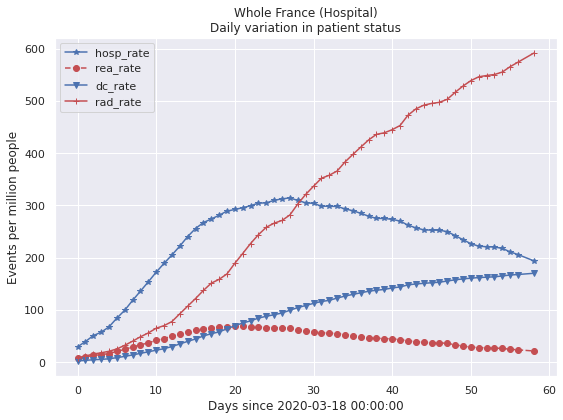

In [16]:
ncolLabs = list ( x+"_rate" for x in colLabs)
df=hdGMJour.loc[:,ncolLabs]
colOpts = {'dc_rate'  : {"c":"b","marker":"v"},  
           'rea_rate' : {"c":"r","marker":"o", "linestyle":"--"},
           'rad_rate' : {"marker":"+"},
           'hosp_rate': {"marker":"*"}
          }

painter = figureTSFromFrame(df)
painter.doPlot()
painter.setAttrs(colOpts=colOpts,
                 xlabel=f"Days since {painter.dt[0]}", 
                 ylabel="Events per million people",
                 title="Whole France (Hospital)\nDaily variation in patient status",
                 legend=True  ) 

PAN.set_option('display.max_colwidth', None)
ImgMgr.save_fig("FIG051")

In [17]:
refDFY = ( df.loc[:,["rad_rate","dc_rate"]] / 1.0e6).copy()
refDFY.columns = ["recovered","dead"]
DFIndexDaysElapsed(refDFY)
t = refDFY.index.values.astype(float)
refDFY1  = refDFY.copy().drop("dteStr", axis=1)
xlabel   = f"Days since {refDFY.iloc[0,:].loc['dteStr'] }"

We need to fix the initial values for infected, exposed; we have values for deceased and recovered....

### Identifying multiple parameters, with multiple data curvese

The definition of `styles` proposes some consistency between figures.

In [18]:
styles = {"susceptible":"b", 
          "exposed":"r+", 
          "ref exposed":"r--",
          "infected":"ro", 
          "quarantined":"p", 
          "recovered":"yo",
          "ref recovered":"y--",
          "dead":"bv-", 
          "ref dead":"b--",
          "insusceptible":"g"
         }


In [19]:
def lambFn(t):          # recovery/cure rate; 
       if t <5:         # estimated date for change in policy/efficiency (t==0 => 18/3; stay at home:15/3)
          return 0.02
       else:
          return 0.04
    
def kappaFn(t):          # mortality rate; 
       if t<10:          # estimated date for change in policy/efficiency (t==0 => 18/3; stay at home:15/3)
          return 3.0e-2
       else:
          return 1.0e-2

In [20]:
initParmDict= toDict( beta = 0.95,     # (default=1) rate of exposition (in prop of susceptibles
                                      #             meeting infected)
                 alpha = 0.06,       # (default=0.085) rate of susceptibles becoming insusceptible
                 delta = 0.1,      # (default=1/7.4 ) inverse average quarantine time
                 gamma = 0.1,       # (default=1/2) inverse average latent time 
                 lamb = lambFn,   # recovery/cure rate
                 kappa=  kappaFn  # mortality rate
                    )

In [21]:
initialVals= toDict( i0 = df.iloc[0,:].loc['hosp_rate']/2.0e6,         # infected (split in 2 halves ??)
                     e0 = df.iloc[0,:].loc['hosp_rate']/2.0e6,         # exposed  (split in 2 halves ??)
                     r0 = df.iloc[0,:].loc['rad_rate']/1.0e6,           # recovered
                     q0 = 0,                  # quarantined
                     d0 = df.iloc[0,:].loc['dc_rate']/1.0e6,                  # dead
                     p0 = 0,                  # insusceptibles
                     s0 = None                # susceptibles defaults to :1 -((i0 + e0 + r0)
        )

In [22]:
model = EPIM.SEIRYOpt3(initParmDict, t, refDFY1, tF = refDFY1.shape[0], initial = initialVals)

In setInitial: initial values for ODE
	i0: infected	->	1.4524067390570782e-05
	e0: exposed	->	1.4524067390570782e-05
	r0: recovered	->	8.003609701764153e-06
	q0: quarantined	->	0
	d0: dead	->	2.139871063471055e-06
	p0: insusceptibles	->	0
	s0: susceptibles	->	0.9999629482555171


--  --  --  parms
beta	->	0.95
alpha	->	0.06
delta	->	0.1
lamb	->	<function lambFn at 0x7f7db1e48e18>
kappa	->	<function kappaFn at 0x7f7db1e48bf8>
gamma	->	0.1
--  --  --  --  --  --  
Saving figure FIG052


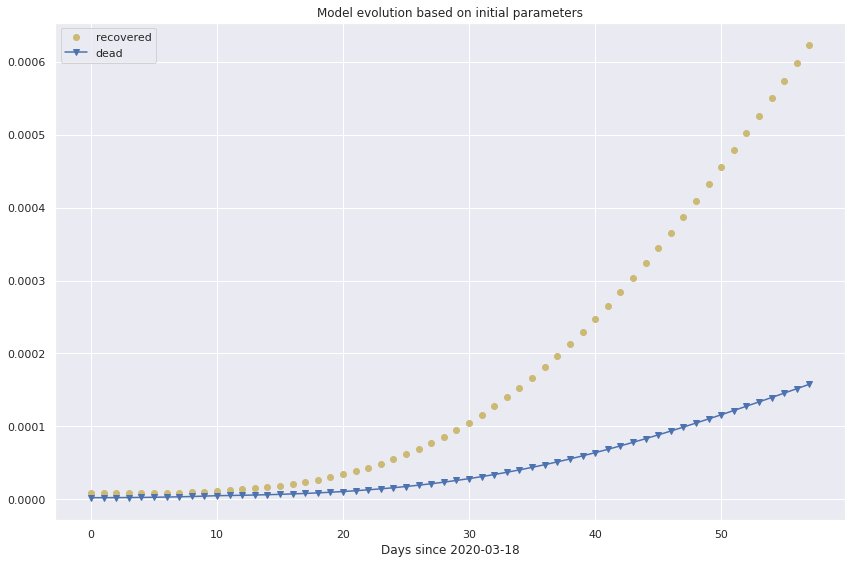

In [23]:
model.eval(None)
model.showParms()
selCols=["recovered","dead"]
ax = model.solDF.loc[:,selCols].plot(style=styles, figsize=(12,8))
PLT.legend(labels=selCols)
PLT.title("Model evolution based on initial parameters")
PLT.xlabel(xlabel)
ImgMgr.save_fig("FIG052")

Saving figure FIG053


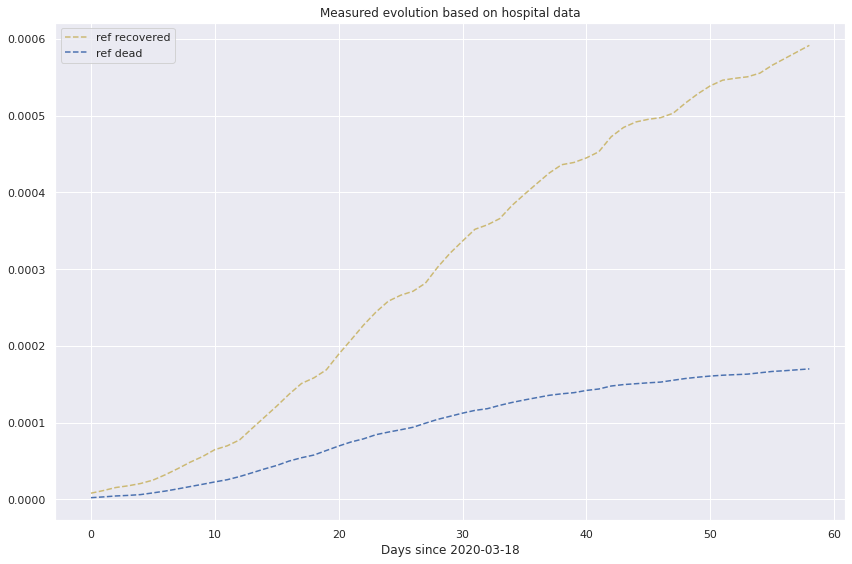

In [24]:
refDFY1b=refDFY1.copy()
refDFY1b.columns = [ "ref " + x  for x in refDFY1b.columns]
refDFY1b.plot(style=styles, figsize=(12,8))
PLT.title("Measured evolution based on hospital data")
PLT.xlabel(xlabel)
ImgMgr.save_fig("FIG053")

In [25]:
initError=model.error(t,refDFY1)
print(f"Initial error:{initError}")

Initial error:1.4607603100007724e-06


The optimization step that follows may take a long time!

In [26]:
def fun(vals, model, ref ):
    model.eval(vals)
    return model.error(t,ref)

optResult=optimize.minimize(fun,[0.5, 0.06, 0.3, 0.2] , args=(model, refDFY1), method='Nelder-Mead')
optResult

 final_simplex: (array([[1.6948251 , 0.06089419, 0.87282052, 0.62232499],
       [1.69481676, 0.06089442, 0.87281188, 0.62232183],
       [1.69486855, 0.06089307, 0.87286232, 0.62234116],
       [1.69489582, 0.06089234, 0.87288977, 0.62235142],
       [1.69485834, 0.06089331, 0.87285426, 0.62233757]]), array([1.22467679e-08, 1.22467691e-08, 1.22467692e-08, 1.22467692e-08,
       1.22467693e-08]))
           fun: 1.2246767902745923e-08
       message: 'Optimization terminated successfully.'
          nfev: 435
           nit: 242
        status: 0
       success: True
             x: array([1.6948251 , 0.06089419, 0.87282052, 0.62232499])

The optimization yields:
	beta	calcul:1.6948251043399525
	alpha	calcul:0.06089419485128146
	delta	calcul:0.8728205219834115
	gamma	calcul:0.6223249946658338
Residual error from optimizer program:1.2246767902745923e-08
Residual error verification:1.2246767902745923e-08
--  --  --  parms
beta	->	1.6948251043399525
alpha	->	0.06089419485128146
delta	->	0.8728205219834115
lamb	->	<function lambFn at 0x7f7db1e48e18>
kappa	->	<function kappaFn at 0x7f7db1e48bf8>
gamma	->	0.6223249946658338
--  --  --  --  --  --  
Saving figure FIG054


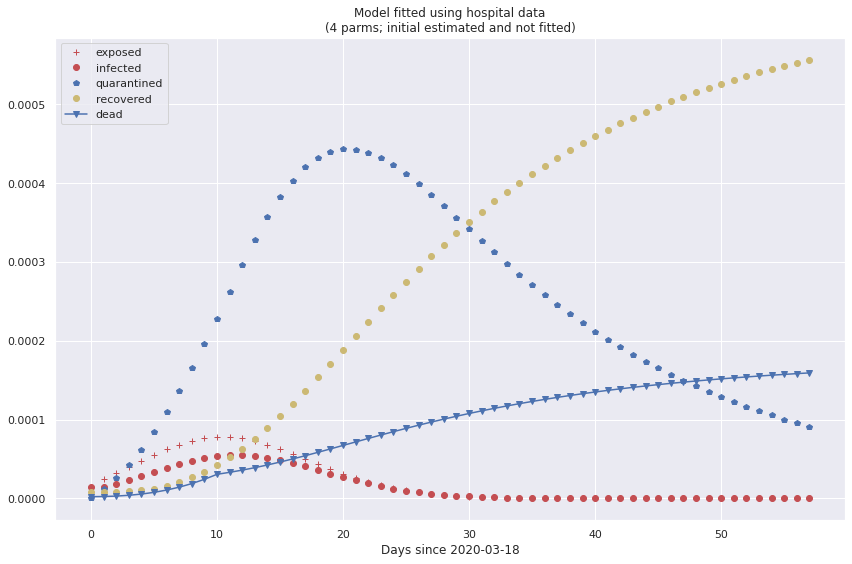

In [27]:
print( f"The optimization yields:")
for z in ( ("beta",0), ("alpha",1),("delta",2 ), ("gamma",3) ):
    print (f"\t{z[0]}\tcalcul:{optResult.x[z[1]]}")

print(f"Residual error from optimizer program:{optResult.fun}")
# recompute the model with identified parameters
errVerif = model.eval(optResult.x)
print(f"Residual error verification:{errVerif}")
model.showParms()
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
ax = model.solDF.loc[:,selCols].plot(style=styles, figsize=(12,8))
PLT.legend(labels=selCols)
PLT.title("Model fitted using hospital data\n(4 parms; initial estimated and not fitted)")
PLT.xlabel(xlabel)
ImgMgr.save_fig("FIG054")

Saving figure FIG055


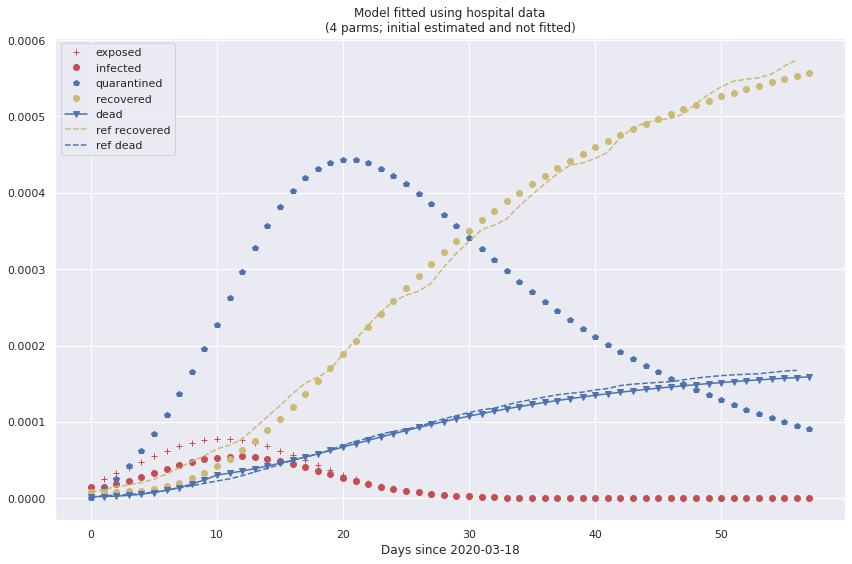

In [28]:
selCols=['exposed', 'infected', 'quarantined', 'recovered', 'dead']
solCopy = model.solDF.loc[:,selCols].copy()
solCopy[ ["ref recovered","ref dead"] ] = refDFY1
selCols.append("ref recovered")
selCols.append("ref dead")
ax = solCopy.loc[:,selCols].plot(style=styles, figsize=(12,8))
PLT.legend(labels=selCols)
PLT.title("Model fitted using hospital data\n(4 parms; initial estimated and not fitted)")
PLT.xlabel(xlabel)
ImgMgr.save_fig("FIG055")